# Libraries

In [71]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats

import tarfile
import urllib.request
from datetime import datetime as dt

import matplotlib.pyplot as plt

In [68]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics.pairwise import rbf_kernel

from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

from sklearn.pipeline import Pipeline, make_pipeline


In [3]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()
housing

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  
0            NEAR BAY  
1            NEAR BAY  
2            NEAR BAY  
3            NEAR BAY  
4            NEAR BAY  
...               ...  
20635          INLAND  
20636          INLAND  
20637          INLAND  
20638          INLAND  
20639          INLAND  

[20640 rows x 10 columns]

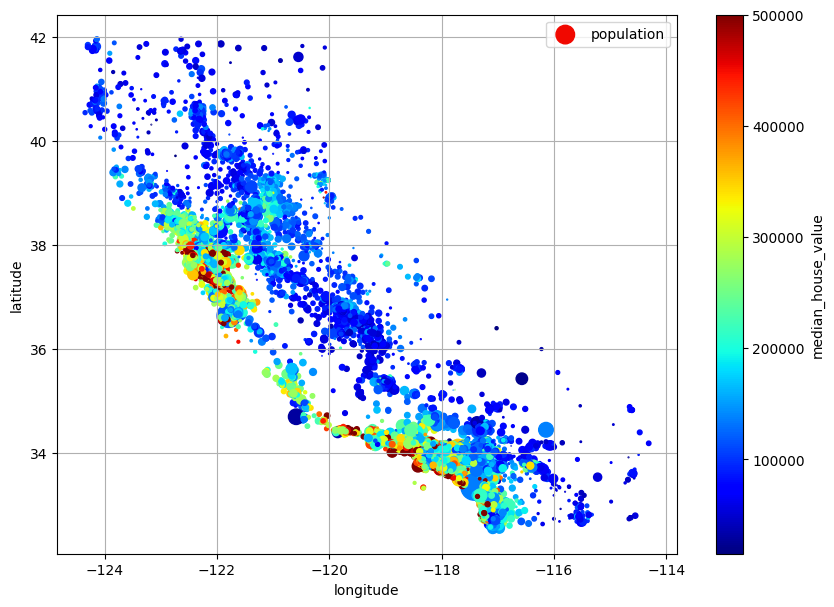

In [4]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
# save_fig("housing_prices_scatterplot")  # extra code
plt.show()

<Axes: xlabel='income_cat'>

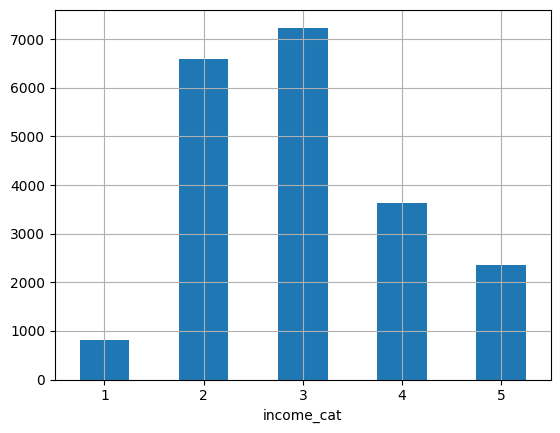

In [5]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

# Stratified Sampling

In [6]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [7]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [8]:
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

# TransformedTargetRegressor

`TransformedTargetRegressor` is useful when we want to interpret predictions in the original scale of the target variable

In [9]:
model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

# FunctionTransformer

`FunctionTransformer` is useful when we want to apply custom data transformations that are not covered by the built-in transformers in scikit-learn

In [18]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])
pd.DataFrame(zip(housing["population"],log_pop['population']), columns=['original', 'log_transformed']).head()

original  log_transformed
0    1576.0         7.362645
1     666.0         6.501290
2     562.0         6.331502
3    1845.0         7.520235
4    1912.0         7.555905

In [19]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

- kw_args=dict(Y=[[35.]], gamma=0.1):
    - $Y=[[35.]]$: This argument represents a fixed value of Y (_target value_) that will be compared with the X values passed to the transformer
    > In this case, it is set to 35, which could be interpreted as a reference point (age 35)
    - $gamma=0.1$: This is the parameter for the RBF kernel, controlling the kernel's width
    > A lower gamma value results in a broader kernel, meaning values far from the reference point will still have some influence, while a higher gamma narrows the influence to nearby points
    - __Results Interpretation__: If an age is close to 35, the similarity will be higher (closer to 1), and if it’s far from 35, the similarity will be lower (closer to 0)

# Latitude Longitude Clustering

In [25]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [26]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

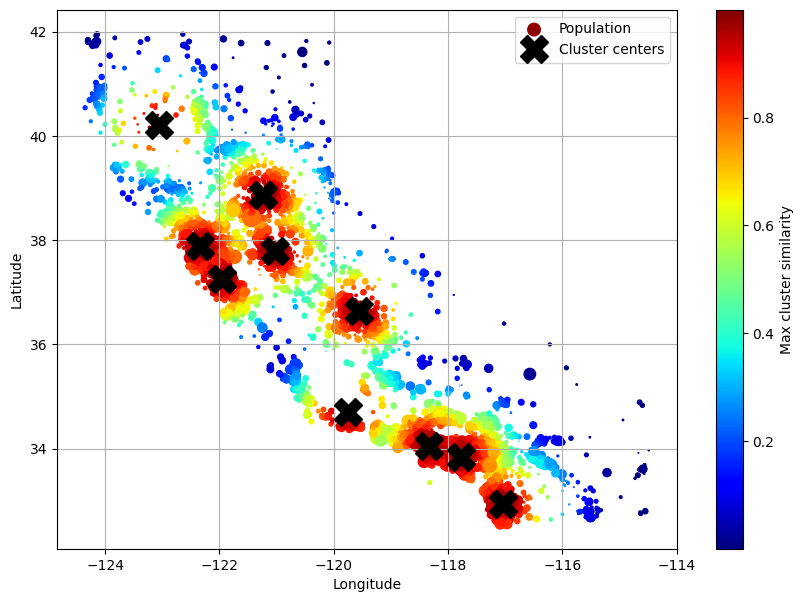

In [24]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
# save_fig("district_cluster_plot")
plt.show()

# Transformation Pipelines

## 1/4) Simple Preprocessing

In [28]:
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [34]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

In [41]:
num_attribs = housing.select_dtypes(exclude="object").columns.to_list()
cat_attribs = housing.select_dtypes(include="object").columns.to_list()

In [42]:
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [43]:
housing_prepared = preprocessing.fit_transform(housing)

In [44]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

num__longitude  num__latitude  num__housing_median_age  \
13096       -1.423037       1.013606                 1.861119   
14973        0.596394      -0.702103                 0.907630   

       num__total_rooms  num__total_bedrooms  num__population  \
13096          0.311912             1.368167         0.137460   
14973         -0.308620            -0.435925        -0.693771   

       num__households  num__median_income  num__income_cat  \
13096         1.394812           -0.936491        -0.954687   
14973        -0.373485            1.171942         1.890078   

       cat__ocean_proximity_<1H OCEAN  cat__ocean_proximity_INLAND  \
13096                             0.0                          0.0   
14973                             1.0                          0.0   

       cat__ocean_proximity_ISLAND  cat__ocean_proximity_NEAR BAY  \
13096                          0.0                            1.0   
14973                          0.0                            0.0   

       cat__ocean_proximity_NEAR OCEAN  
13096                              0.0  
14973                              0.0

## 2/4) Nested Preprocessing

In [47]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [48]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared

array([[ 1.84662439, -0.86602737, -0.33020372, ...,  0.        ,
         1.86111875, -0.95468705],
       [-0.5081207 ,  0.0245495 , -0.25361631, ...,  0.        ,
         0.90762971,  1.89007821],
       [-0.20215476, -0.04119332, -0.05104091, ...,  0.        ,
         0.35142777, -0.95468705],
       ...,
       [-0.24249175, -0.10998748,  0.15854151, ...,  1.        ,
        -1.23772062, -0.00643196],
       [ 0.25977479, -0.36093745, -0.21033248, ...,  0.        ,
         0.66925745, -0.00643196],
       [ 3.61270996, -1.32397227,  0.04958379, ...,  1.        ,
         1.22545939, -0.00643196]])

In [53]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age', 'remainder__income_cat'],
      dtype=object)

In [54]:
pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out())

bedrooms__ratio  rooms_per_house__ratio  people_per_house__ratio  \
0             1.846624               -0.866027                -0.330204   
1            -0.508121                0.024550                -0.253616   
2            -0.202155               -0.041193                -0.051041   
3            -0.149006               -0.034858                -0.141475   
4             0.963208               -0.666554                -0.306148   
...                ...                     ...                      ...   
16507         0.804368               -0.452111                -0.269780   
16508        -0.192328                0.036792                -0.073741   
16509        -0.242492               -0.109987                 0.158542   
16510         0.259775               -0.360937                -0.210332   
16511         3.612710               -1.323972                 0.049584   

       log__total_bedrooms  log__total_rooms  log__population  \
0                 1.324114          0.637892         0.456906   
1                -0.252671         -0.063576        -0.711654   
2                -0.925266         -0.859927        -0.941997   
3                 0.952773          0.943475         0.670700   
4                 1.437622          1.003590         0.719093   
...                    ...               ...              ...   
16507             0.465581          0.109720        -0.247054   
16508             0.454022          0.477277         0.314542   
16509             0.824206          0.859552         1.243381   
16510             0.987851          0.811293         0.579462   
16511            -1.072179         -2.091543        -0.679447   

       log__households  log__median_income  geo__Cluster 0 similarity  \
0             1.310369           -1.071522               8.708837e-08   
1            -0.142030            1.194712               1.181328e-01   
2            -0.913030           -0.756981               2.295286e-08   
3             0.925373           -0.912253               4.618947e-04   
4             1.481464            0.034537               3.166634e-02   
...                ...                 ...                        ...   
16507         0.379471            0.648953               7.592469e-02   
16508         0.402773           -0.637675               1.122830e-01   
16509         0.889897            0.333540               6.789654e-06   
16510         1.023329            0.377051               1.096450e-01   
16511        -0.853784           -0.119155               2.045370e-07   

       geo__Cluster 1 similarity  ...  geo__Cluster 7 similarity  \
0                   9.712456e-01  ...               3.070969e-17   
1                   9.738096e-14  ...               5.437838e-01   
2                   7.457782e-01  ...               1.605970e-17   
3                   3.873884e-20  ...               7.405721e-01   
4                   7.905346e-16  ...               7.501278e-01   
...                          ...  ...                        ...   
16507               1.255430e-14  ...               5.539064e-01   
16508               8.422138e-06  ...               1.831519e-04   
16509               3.595707e-25  ...               1.250634e-01   
16510               6.165959e-14  ...               5.435921e-01   
16511               9.177923e-01  ...               9.839318e-17   

       geo__Cluster 8 similarity  geo__Cluster 9 similarity  \
0                   1.314047e-01               5.740031e-01   
1                   1.735342e-09               2.275194e-10   
2                   2.744847e-01               2.839978e-01   
3                   2.243339e-14               4.218649e-16   
4                   2.890866e-11               3.710912e-12   
...                          ...                        ...   
16507               2.304608e-10               4.272885e-11   
16508               6.702758e-03               4.498431e-04   
16509               3.348665e-19               2.064542e-20   
1

### Model Training

In [55]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000266753DF9A0>)])),
                ('linearregression', LinearRegression())])

In [56]:
housing_predictions = lin_reg.predict(housing) # Predicting on training dataset only
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [57]:
lin_rmse = mean_squared_error(
    housing_labels, housing_predictions
    , squared=False)
lin_rmse

68004.5246946409

> Consolidating all of LinReg in 1 cell block

In [69]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)
housing_predictions = lin_reg.predict(housing) # Predicting on training dataset only
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred
print(housing_labels.iloc[:5].values)
lin_rmse = mean_squared_error(
    housing_labels, housing_predictions
    , squared=False)
lin_rmse

[458300. 483800. 101700.  96100. 361800.]


68004.5246946409

In [61]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

0.0

In [65]:
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     66828.991942
std       2109.500358
min      63504.013557
25%      65456.007554
50%      66483.337336
75%      68375.606282
max      70322.608451
dtype: float64

In [66]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69092.200605
std       3689.500079
min      65042.044581
25%      67538.125253
50%      68279.448225
75%      69282.105447
max      78664.312855
dtype: float64

In [67]:
forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47007.661117
std       1071.885942
min      45438.898450
25%      46378.232205
50%      47090.462095
75%      47406.931316
max      49311.141107
dtype: float64

## 3/4) Grid Search

In [73]:
print(dt.now())
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(
    full_pipeline, param_grid
    , cv=3,scoring='neg_root_mean_squared_error'
    , verbose = 3
)
grid_search.fit(housing, housing_labels)
print(dt.now())

2024-09-16 21:20:38.546798
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=4;, score=-48176.902 total time=  23.6s
[CV 2/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=4;, score=-48463.444 total time=  22.3s
[CV 3/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=4;, score=-49634.126 total time=  22.4s
[CV 1/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=6;, score=-48271.017 total time=  31.6s
[CV 2/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=6;, score=-48335.107 total time=  29.0s
[CV 3/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=6;, score=-49411.427 total time=  30.9s
[CV 1/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=8;, score=-48582.744 total time=  34.7s
[CV 2/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=8;, score=-48569.742 total time=

In [74]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [75]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000026...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000266031313C0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [76]:
final_model = grid_search.best_estimator_  # includes preprocessing

## 4/4) Consolidating

In [78]:
final_model = grid_search.best_estimator_

# If the final model is a RandomForestRegressor or similar, set random_state=42
if hasattr(final_model, 'random_state'):
    final_model.random_state = 42

final_rmse = -cross_val_score(final_model, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(final_rmse).describe()

count       10.000000
mean     43852.083148
std        975.624182
min      42043.737781
25%      43439.803813
50%      43957.601733
75%      44464.772228
max      45280.765205
dtype: float64

# Evaluating on Test

In [79]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

43977.65894909815


# Confidence Interval

This code is calculating a confidence interval for the root mean squared error (RMSE) of the predictions

In [84]:
confidence = 0.95

This sets the confidence level at 95%. It means that the confidence interval will estimate the range in which the true RMSE lies with 95% confidence.

In [80]:
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([41820.56485734, 46033.78464019])

This means you can be 95% confident that the true RMSE lies within this interval.

If the output is (50000, 60000), it means that the true RMSE is likely to be between 50,000 and 60,000 with 95% confidence.

In [83]:
# extra code – computes a confidence interval again using a z-score
m = len(squared_errors)
mean = squared_errors.mean()
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(41821.21379613474, 46033.195086854175)